In [4]:
!pip install -U ydata-profiling

  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=71f419be63d147b6bfa22ffaa16fd5946af8fe1922a1febfd4706dc8976f425a
  Stored in directory: c:\users\ajed8\appdata\local\pip\cache\wheels\1d\05\04\c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1


In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Load dataset

In [2]:
df = pd.read_csv("TCGA_InfoWithGrade.csv")

# Use ydata-profile to compile overview of the dataset

In [3]:
profile = ProfileReport(df, title="Profiling Report")

In [4]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Actions based on Profile Report 
The dataset had already removed any records that had missing data, and any attributes that were unique for every record (Record ID for example) as this would have caused dimensionality problems later on. The only indicated problem with the dataset is a duplicated record that I will remove.

In [15]:
df = df.drop_duplicates()


# Further data investigations
I want to look in more detail firstly at the correlations between attributes - part of my investigation is to look at the optimum group of features to keep for modelling, but I also want to see if it is worth combining features by feature crossing.

I also want visualise the diffrent numbers of mutant genes for both LGG and GBM, and to look at whether the Age_at_diagnosis distribution differs for each Grade, and also if the there any obvious Race differences.

## Correlations

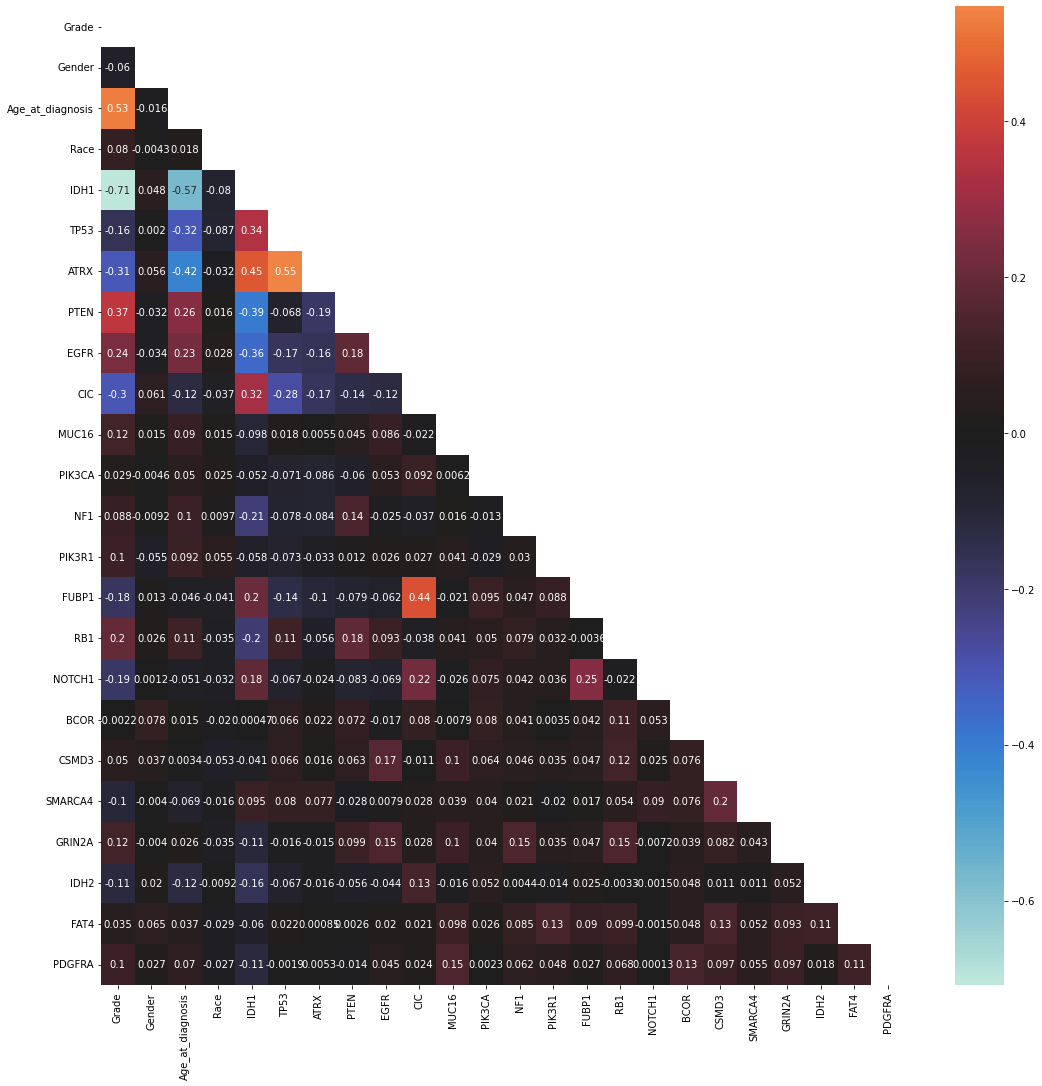

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

# Generate correlation matrix
corr_matrix = df.corr()

# Create a mask to hide the values on one side of the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the figure size
plt.figure(figsize=(18, 18))

# Create the heatmap with masked values
sns.heatmap(corr_matrix, mask=mask, center=0, annot=True)

# Show the plot
plt.show()


In [28]:
# Get the absolute correlation values and sort them in descending order
correlation_values = corr_matrix.abs().unstack().sort_values(ascending=False)

# Filter out the diagonal and duplicates (lower triangle)
correlation_values = correlation_values[correlation_values.index.get_level_values(0) != correlation_values.index.get_level_values(1)]

# Remove duplicate correlations by keeping only one version of each pair
correlation_pairs = set()
unique_correlations = []
excluded_features = ['Race', 'Age_at_diagnosis', 'Grade']  # Features to exclude

for correlation in correlation_values.index:
    pair = tuple(sorted(correlation))
    if pair not in correlation_pairs and not any(feature in pair for feature in excluded_features):
        correlation_pairs.add(pair)
        unique_correlations.append((correlation, corr_matrix.loc[correlation]))

# Specify the number of largest correlations to display
num_largest_correlations = 10

# Get the top N largest correlations
largest_correlations = unique_correlations[:num_largest_correlations]

# Print the list of largest correlations
print("Top", num_largest_correlations, "gene correlations:")
for correlation, corr_value in largest_correlations:
    print(f"{correlation[0]} - {correlation[1]}: {corr_value:.4f}")

Top 10 gene correlations:
TP53 - ATRX: 0.5459
IDH1 - ATRX: 0.4539
CIC - FUBP1: 0.4379
PTEN - IDH1: -0.3946
IDH1 - EGFR: -0.3570
TP53 - IDH1: 0.3400
IDH1 - CIC: 0.3214
CIC - TP53: -0.2785
FUBP1 - NOTCH1: 0.2534
CIC - NOTCH1: 0.2194


In [27]:
# Generate correlation matrix
corr_matrix = df.corr()

# Filter the correlation matrix to only include correlations where 'Grade' is present
grade_correlations = corr_matrix.loc[:, 'Grade'].dropna()

# Remove self-correlation (correlation of 'Grade' with itself)
grade_correlations = grade_correlations[grade_correlations.index != 'Grade']

# Sort correlations by absolute magnitude (ignoring + or -)
sorted_correlations = grade_correlations.abs().sort_values(ascending=False)

# Print the list of correlations involving 'Grade' ordered by magnitude
print("Correlations involving 'Grade' (ordered by magnitude):")
for feature in sorted_correlations.index:
    correlation = grade_correlations[feature]
    print(f"{feature}: {correlation:.4f}")


Correlations involving 'Grade' (ordered by magnitude):
IDH1: -0.7078
Age_at_diagnosis: 0.5287
PTEN: 0.3669
ATRX: -0.3136
CIC: -0.3040
EGFR: 0.2413
RB1: 0.1950
NOTCH1: -0.1855
FUBP1: -0.1813
TP53: -0.1608
MUC16: 0.1191
GRIN2A: 0.1186
IDH2: -0.1134
PDGFRA: 0.1022
PIK3R1: 0.1016
SMARCA4: -0.1005
NF1: 0.0879
Race: 0.0798
Gender: -0.0609
CSMD3: 0.0501
FAT4: 0.0346
PIK3CA: 0.0286
BCOR: -0.0024


## Gene distributions

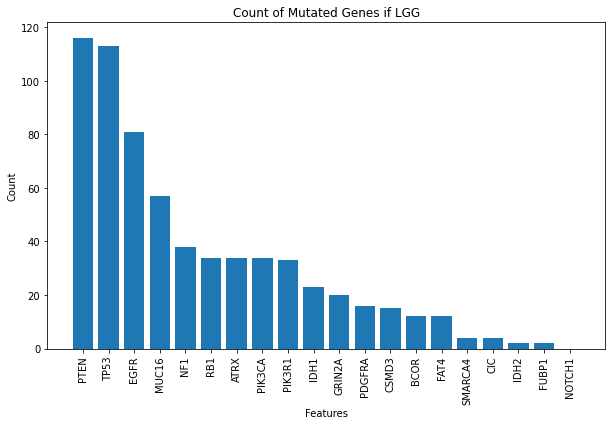

In [4]:
# Filter the DataFrame based on df['Grade'] == 1
one_df = df[df['Grade'] == 1]

# Drop the 'Grade' column from the filtered DataFrame
filtered_one_df = one_df.drop(['Grade', 'Gender','Age_at_diagnosis', 'Race'], axis=1)

# Calculate the count of occurrences of 1 in each column
count_ones = filtered_one_df.eq(1).sum()

# Sort the counts in ascending order
count_ones = count_ones.sort_values(ascending=False)

# Plot the histogram
plt.bar(count_ones.index, count_ones.values)

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Count of Mutated Genes if LGG')
plt.xticks(rotation='vertical')

# Display the histogram
plt.show()


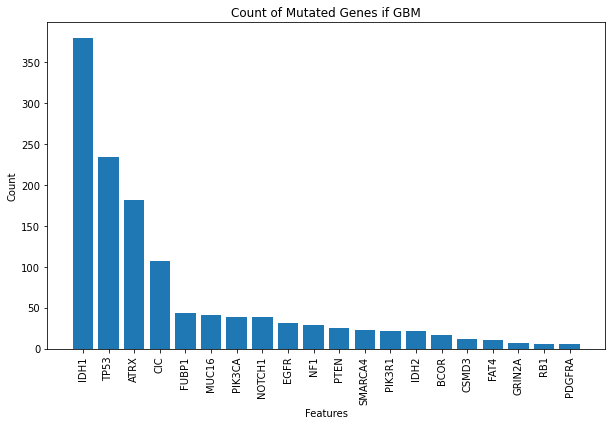

In [5]:
# Filter the DataFrame based on df['Grade'] == 0
zero_df = df[df['Grade'] == 0]

# Drop the 'Grade' column from the filtered DataFrame
filtered_zero_df = zero_df.drop(['Grade','Gender', 'Age_at_diagnosis', 'Race'], axis=1)

# Calculate the count of occurrences of 1 in each column
count_ones = filtered_zero_df.eq(1).sum()

# Sort the counts in ascending order
count_ones = count_ones.sort_values(ascending=False)

# Plot the histogram
plt.bar(count_ones.index, count_ones.values)

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Count of Mutated Genes if GBM')
plt.xticks(rotation='vertical')

# Display the histogram
plt.show()


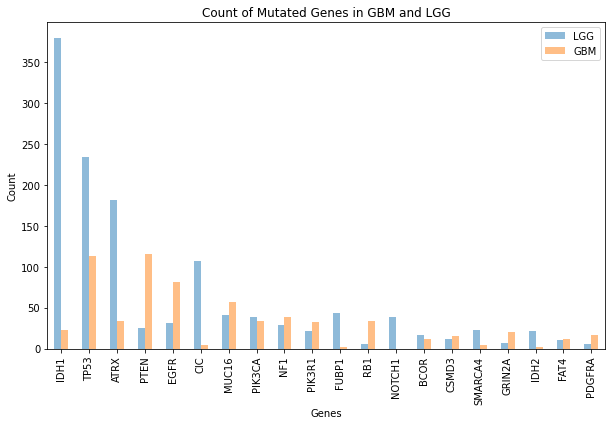

In [21]:
newdf = df.drop(['Gender', 'Age_at_diagnosis', 'Race'], axis=1)
# Group the DataFrame by 'Grade' and calculate the counts of 1 in each column
counts = newdf.groupby("Grade").sum()

# Plot the histogram
counts.T.plot(kind="bar", alpha=0.5)

# Adding labels and title

plt.xlabel("Genes")
plt.ylabel("Count")
plt.title("Count of Mutated Genes in GBM and LGG")

# Rotating x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Adding legend
plt.legend(["LGG", "GBM"])

# Display the histogram
plt.show()


## Age distribution

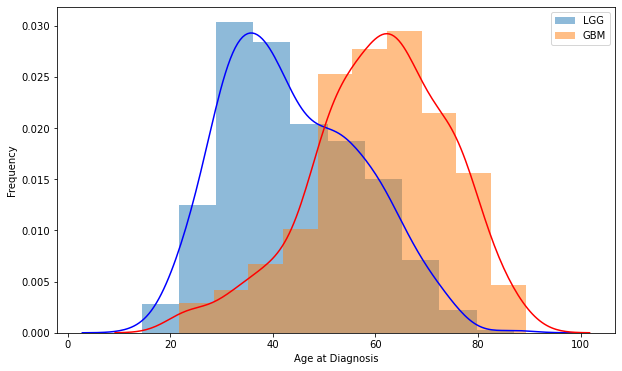

In [7]:
# Plot for Grade == 0
plt.hist(zero_df['Age_at_diagnosis'], bins=10, alpha=0.5, label='LGG', density=True)

# Plot for Grade == 1
plt.hist(one_df['Age_at_diagnosis'], bins=10, alpha=0.5, label='GBM', density=True)

# Plot for Grade == 0
sns.kdeplot(zero_df['Age_at_diagnosis'], color='blue')

# Plot for Grade == 1
sns.kdeplot(one_df['Age_at_diagnosis'], color='red')


# Add labels and legend
plt.xlabel('Age at Diagnosis')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


In [11]:
# Calculate statistics for Grade 0
grade0_mean = np.mean(zero_df['Age_at_diagnosis'])
grade0_sd = np.std(zero_df['Age_at_diagnosis'])
grade0_iqr = np.percentile(zero_df['Age_at_diagnosis'], 75) - np.percentile(zero_df['Age_at_diagnosis'], 25)

# Calculate statistics for Grade 1
grade1_mean = np.mean(one_df['Age_at_diagnosis'])
grade1_sd = np.std(one_df['Age_at_diagnosis'])
grade1_iqr = np.percentile(one_df['Age_at_diagnosis'], 75) - np.percentile(one_df['Age_at_diagnosis'], 25)

# Create a table using pandas DataFrame
statistics_table = pd.DataFrame({
    'Grade': ['LGG', 'GBM'],
    'Mean': [grade0_mean, grade1_mean],
    'SD': [grade0_sd, grade1_sd],
    'IQR': [grade0_iqr, grade1_iqr]
})

# Display the table
print(statistics_table)


  Grade       Mean         SD      IQR
0   LGG  43.892819  13.255848  20.2325
1   GBM  60.703750  13.407994  17.3300


In [42]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(zero_df['Age_at_diagnosis'], one_df['Age_at_diagnosis'], alternative='two-sided')

# Print the results
print("Mann-Whitney U test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U test:
Statistic: 32478.5
P-value: 4.048043076729144e-53


## Race distribution

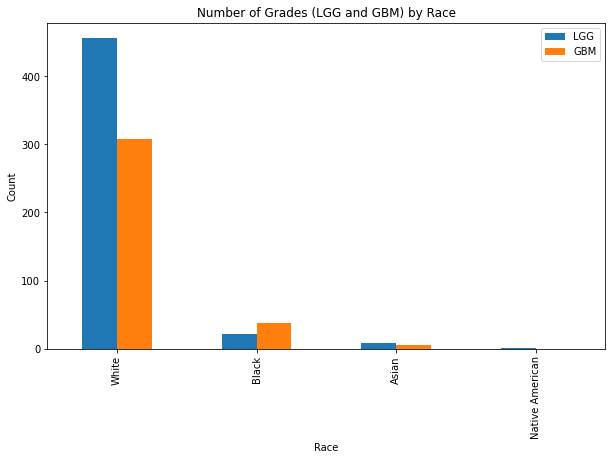

In [8]:
# Group the dataframe and create the grouped variable
grouped = df.groupby(['Race', 'Grade']).size().unstack()

# Plot the bar chart
ax = grouped.plot(kind='bar', stacked=False)

# Add labels and title
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Number of Grades (LGG and GBM) by Race')
plt.legend(["LGG", "GBM"])

# Set the x-axis tick labels
ax.set_xticklabels(["White", "Black", "Asian", "Native American"])


# Display the plot
plt.show()

# Feature Normalisation
As all features other than Age_at_diagnosis are 0 or 1 (Race being the exception with 0-3), Age could have an exagerated effect on any models. Therefore, I will be using z-score normalisation to reduce this impact.

I also do want to decrease the impact of the number values of the categoric 'Race' attribute - Native American is not a larger value that White. I will use One-Hot encoding to do this.

In [29]:
# Calculate the z-scores
z_scores = (df["Age_at_diagnosis"] - np.mean(df["Age_at_diagnosis"])) / np.std(df["Age_at_diagnosis"])

# Insert the z-scores as a new column in the dataframe
df["z_ages_at_diagnosis"] = z_scores

# Remove the original "Age_at_diagnosis" column
df.drop("Age_at_diagnosis", axis=1, inplace=True)

In [42]:
# Perform one-hot encoding using pandas
one_hot_encoded = pd.get_dummies(df["Race"], prefix="race")

# Concatenate the one-hot encoded columns with the original dataframe
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

# Remove the original "race" column
df_encoded.drop("Race", axis=1, inplace=True)


In [43]:
df_encoded.to_csv("Cleaned.csv", index=False)